## Introduction

This notebook addresses the inequality of educational opportunity in U.S. high schools. We are focusing on average student performance on the ACT or SAT exams that students take as part of the college application process and if socioeconomic factors may be used to predict school performance.

## Import libraries

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries
# Train-test splits
from sklearn.model_selection import train_test_split

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

from os import name
from itertools import combinations

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

#Geographic
import plotly.offline as po
import plotly.graph_objs as pg

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [84]:
# training data
df_train = pd.read_csv('https://raw.githubusercontent.com/lbomine/Education-Inequality/main/clean_education_train.csv')

In [85]:
# testing data
df_test = pd.read_csv('https://raw.githubusercontent.com/lbomine/Education-Inequality/main/clean_education_test.csv')

In [86]:
# dummy variables for additional step
df_dummy = pd.read_csv('https://raw.githubusercontent.com/lbomine/Education-Inequality/main/dummy_requirement.csv')

##### $\rightarrow$ Review the contents of the data set.

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5781 entries, 0 to 5780
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   median_income      5781 non-null   float64
 1   percent_college    5781 non-null   float64
 2   percent_lunch      5781 non-null   float64
 3   percent_married    5781 non-null   float64
 4   rate_unemployment  5781 non-null   float64
 5   school_level       5781 non-null   object 
 6   school_type        5781 non-null   object 
 7   state              5781 non-null   object 
 8   year               5781 non-null   object 
 9   zip_code           5781 non-null   int64  
 10  average_act        5781 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 496.9+ KB


In [88]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   median_income      1446 non-null   float64
 1   percent_college    1446 non-null   float64
 2   percent_lunch      1446 non-null   float64
 3   percent_married    1446 non-null   float64
 4   rate_unemployment  1446 non-null   float64
 5   school_level       1446 non-null   object 
 6   school_type        1446 non-null   object 
 7   state              1446 non-null   object 
 8   year               1446 non-null   object 
 9   zip_code           1446 non-null   int64  
 10  average_act        1446 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 124.4+ KB


## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, we proposed questions about the data.


##### $\rightarrow$ Questions about the data that will help solve the problem.


1. What is the relationship between the requirement for students to take the ACT/SAT and the average scores on these tests across different states?
2. Since the data does not include all the states, does this affect the relationship between ACT performance and socioeconomic factors? Can the inclusion of ACT/SAT requirements help counteract this bias?


## Analysis

We first want to understand the data we are working with and see if there are any potential relationships. To start, I created a pair plot to identify relationships while keeping only meaningful variables.

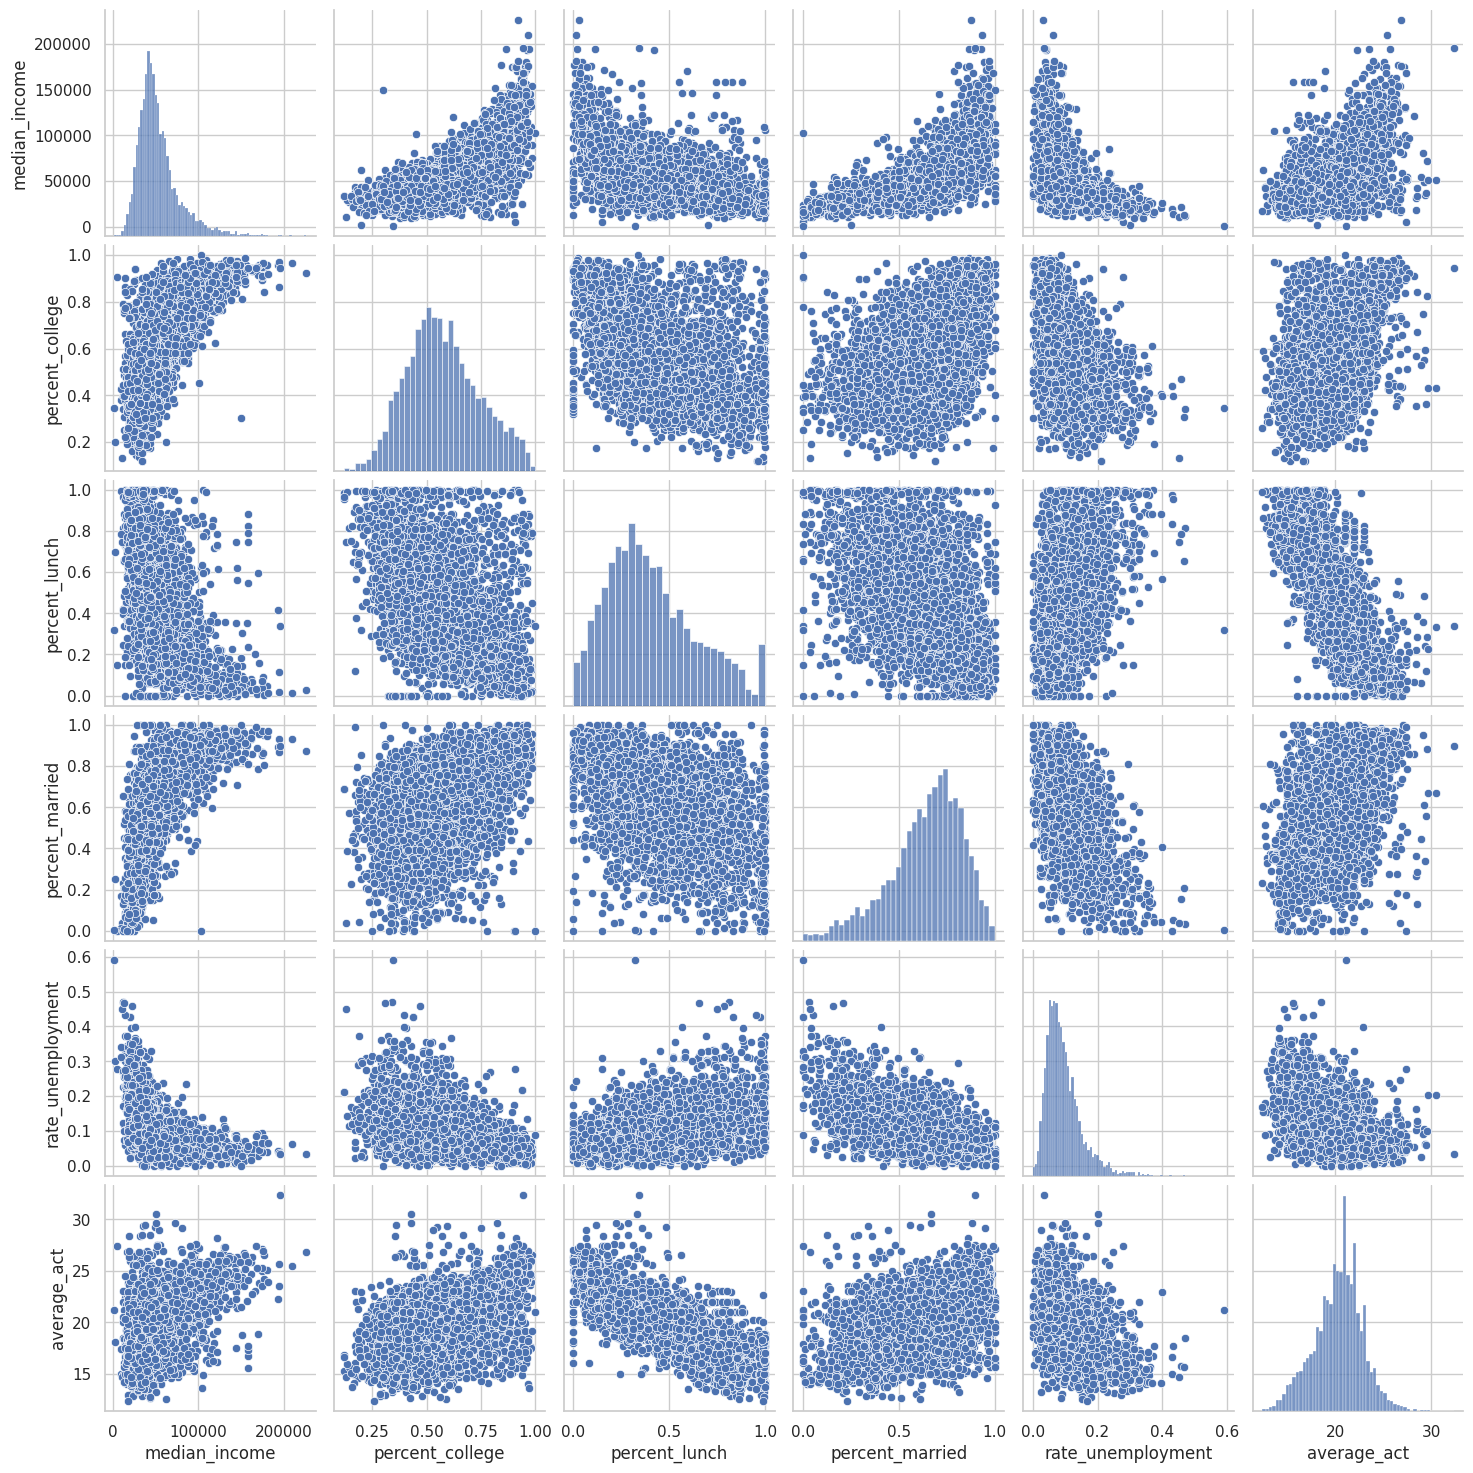

In [89]:
sns.pairplot(df_train.drop(columns = ['school_level','school_type','year','zip_code']))

There are notable trends with between variables `average_act` and `percent_lunch`, `percent_college`, and `percent_lunch`. They look to have linear values in their plots. 

Creating a heat map to visualize the positive and negative relationships.

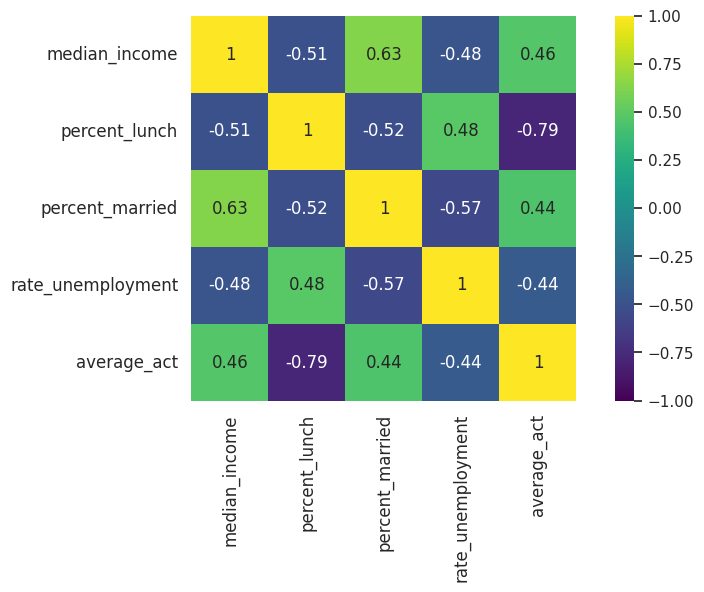

In [90]:
corr_matrix = df_train.loc[:,['median_income','percent_lunch','percent_married','rate_unemployment','average_act']].corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')
plt.tick_params(labelsize=12);

From the output we can see that `percent_lunch` and `average_act` have a strong negative correlation. This shows that students who recieve free or reduced lunch are more likely to be associated with low average ACT scores. The `percent_married` and `meadian_income` variables have a strong positive correlation. This suggests that married individuals have higher incomes.

## Regression Models

### $\rightarrow$ Compare `average_act` with All Variables

From our analysis above we will first compare the `average_act` with all the other predictors to determine which variables are significant for our analysis.

In [91]:
model_all = smf.ols(formula = 'average_act ~ percent_lunch + median_income + percent_married + percent_college + rate_unemployment', data = df_train).fit()

In [92]:
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1985.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:48:43   Log-Likelihood:                -10654.
No. Observations:                5781   AIC:                         2.132e+04
Df Residuals:                    5775   BIC:                         2.136e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.7774      0.15

The R-squared value shows 63% variance for the `average_act`.
Out of all the predictors, `percent_lunch` had the lowest standard error of 0.108. This implies that `percent_lunch` is the most important predictor in the overall model.

### $\rightarrow$  Compare `average_act` with Individual Variables

#### Percent Lunch

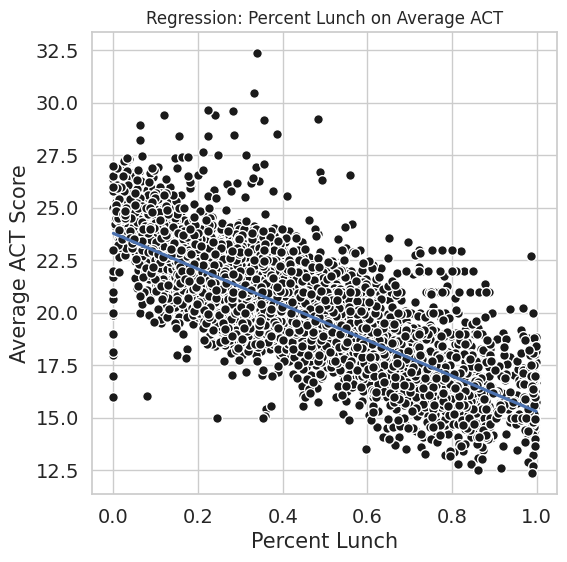

In [93]:
plt.figure(figsize=(6,6))

plt.plot(df_train['percent_lunch'], df_train['average_act'], 'ko', mec='w', ms=7)

sns.regplot(data=df_train, x='percent_lunch', y='average_act', order=1, scatter=False, ci=None)

plt.title('Regression: Percent Lunch on Average ACT')
plt.xlabel('Percent Lunch', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

plt.tick_params(labelsize=14);

There is a strong negative relationship between `average_act` and `percent_lunch`.

#### Median Income



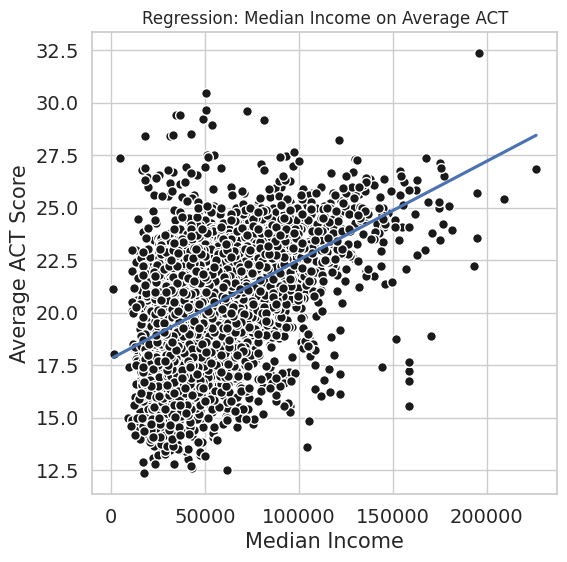

In [94]:
plt.figure(figsize=(6,6))

plt.plot(df_train['median_income'], df_train['average_act'], 'ko', mec='w', ms=7)

sns.regplot(data=df_train, x='median_income', y='average_act', order=1, scatter=False, ci=None)

plt.title('Regression: Median Income on Average ACT')
plt.xlabel('Median Income', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

plt.tick_params(labelsize=14);

There is a strong positive relationship between `average_act` and `median_income`.

#### Percent Married

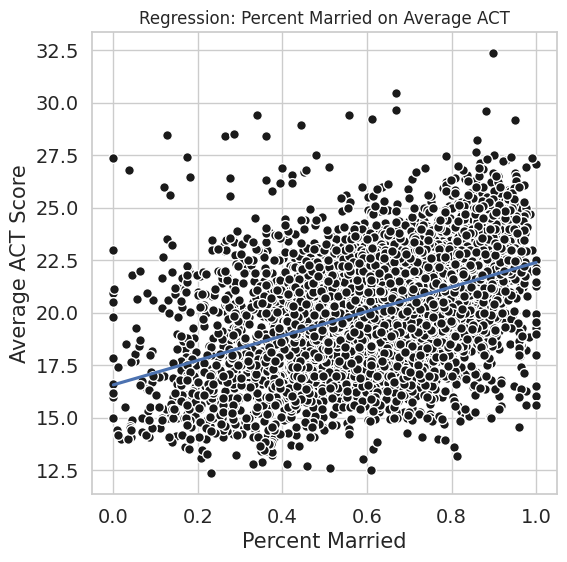

In [95]:
plt.figure(figsize=(6,6))

plt.plot(df_train['percent_married'], df_train['average_act'], 'ko', mec='w', ms=7)

sns.regplot(data=df_train, x='percent_married', y='average_act', order=1, scatter=False, ci=None)

plt.title('Regression: Percent Married on Average ACT')
plt.xlabel('Percent Married', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

plt.tick_params(labelsize=14);

There is a positive relationship between `average_act` and `percent_married`.

#### Percent College

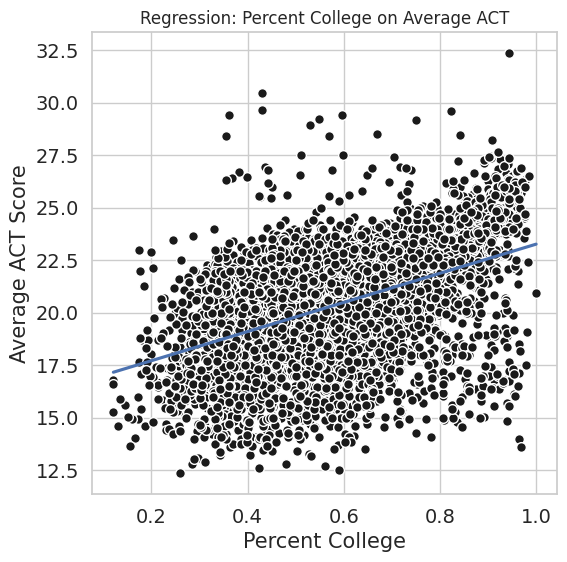

In [96]:
plt.figure(figsize=(6,6))

plt.plot(df_train['percent_college'], df_train['average_act'], 'ko', mec='w', ms=7)

sns.regplot(data=df_train, x='percent_college', y='average_act', order=1, scatter=False, ci=None)

plt.title('Regression: Percent College on Average ACT')
plt.xlabel('Percent College', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

plt.tick_params(labelsize=14);

There is a positive relationship between `average_act` and `percent_college`.

#### Rate Unemployment

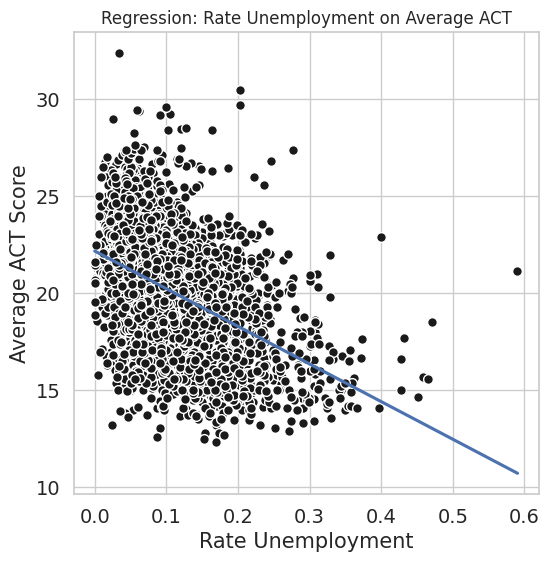

In [97]:
plt.figure(figsize=(6,6))

plt.plot(df_train['rate_unemployment'], df_train['average_act'], 'ko', mec='w', ms=7)

sns.regplot(data=df_train, x='rate_unemployment', y='average_act', order=1, scatter=False, ci=None)

plt.title('Regression: Rate Unemployment on Average ACT')
plt.xlabel('Rate Unemployment', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

plt.tick_params(labelsize=14);

There is a negative relationship between `average_act` and `rate_unemployment`. This plot is left skewed.

Overall, `percent_lunch` has the strongest relationship with `average_act`.

## Best Subset Selection

To make the an accurate prediction, we need to figure out the useful number of predictors to use. We will measure this by calculating the adjusted R-squared and AIC/BIC.

Once we have the best number of predictors we can compare them using those measures to determine which one is the best. This helps us make accurate predictions while maintaining a consise model.

Create new arrays to hold the meaningful predictor variables and target variables for the subset.

In [98]:
X = df_train[df_train.columns.difference(['average_act','school_level','school_type','zip_code','state','year'])]
y = df_train['average_act']

Creating a function to return AIC/BIC, and adjusted R-squared values for use in best subset selection.

In [99]:
def best_subset_selection(X, y):
    """ This function returns AIC, BIC, and adjusted R-squared values for use in best subset selection.

    Inputs
    ------
    X : array-like, shape (n_samples, n_features)
        Predictor values

    y : array-like, shape (n_samples, )
        Target values

    Returns
    ------
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors
   
    """

    variable_names = X.columns.values

    number_variables = len(variable_names)

    # Initialize empty arrays to hold the AIC, BIC, and adjusted r-squared for the best model 
    # at each number of predictors
    best_aic = np.zeros(number_variables)
    best_bic = np.zeros(number_variables)
    best_adjusted_rsquared = np.zeros(number_variables)

    # Initialize empty list to hold the names of the best predictors at each number of predictors
    best_predictors = list()

    # Loop over possible numbers of predictors
    for k in range(number_variables):

        # Get the names of all combinations of k+1 predictors
        subset_names = list(combinations(variable_names, k+1))

        # Loop over all models with k+1 predictors
        for n, predictor_names in enumerate(subset_names):

            # Fit the model
            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(y, sm.add_constant(predictors_subset)).fit() 

            # Initialize the best values with the first model
            if n == 0:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

            # If a model has a better r-squared, update the best values
            elif model.rsquared > best_rsquared_k:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

        # Record the values for the best model at this number of predictors
        best_bic[k] = best_bic_k
        best_aic[k] = best_aic_k
        best_adjusted_rsquared[k] = best_adjusted_rsquared_k
        best_predictors.append(best_predictors_k)

    return best_aic, best_bic, best_adjusted_rsquared, best_predictors

Creating a function to plot the est AIC, BIC, and adjusted R-squared values at each number of possible predictors.

In [100]:
def plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors):
    """ Plot the best AIC, BIC, and adjusted R-squared values at each number of possible predictors

    Input
    -----
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    number_predictors = np.arange(len(best_aic))+1

    plt.subplots(1,3, figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(number_predictors, best_aic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_aic)], np.min(best_aic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('AIC', fontsize=18)
    plt.title(best_predictors[np.argmin(best_aic)])

    plt.subplot(1,3,2)
    plt.plot(number_predictors, best_bic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_bic)], np.min(best_bic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('BIC', fontsize=18)
    plt.title(best_predictors[np.argmin(best_bic)])

    plt.subplot(1,3,3)
    plt.plot(number_predictors, best_adjusted_rsquared, 'b-o');
    plt.plot(number_predictors[np.argmax(best_adjusted_rsquared)], np.max(best_adjusted_rsquared), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('Adjusted R-squared', fontsize=18)
    plt.title(best_predictors[np.argmax(best_adjusted_rsquared)])

    plt.subplots_adjust(wspace = 0.3)

Determing the best subset of predictor variables for each number of predictors.

In [101]:
best_aic, best_bic, best_adjusted_rsquared, best_predictors = best_subset_selection(X, y)

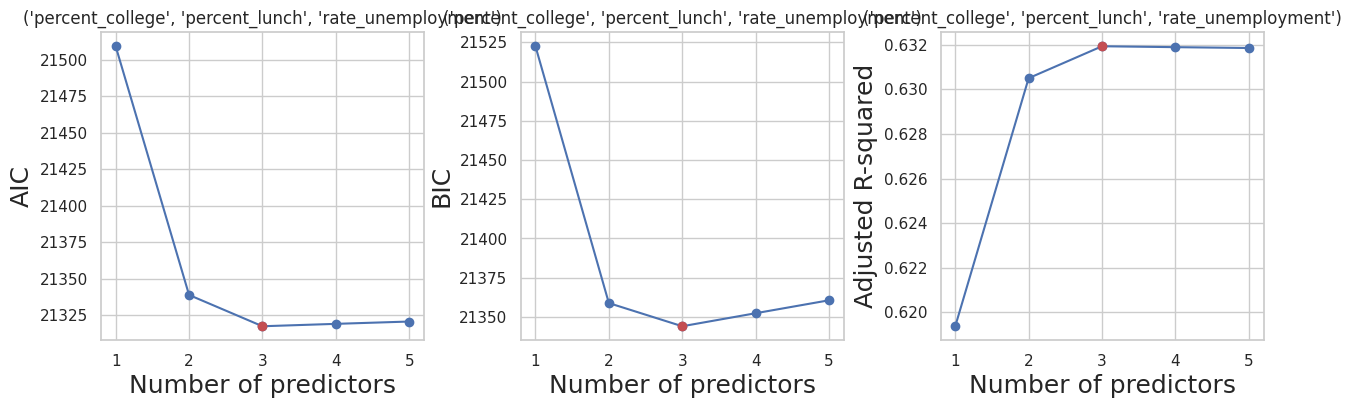

In [102]:
plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors)

Our analysis shows that `percent_lunch` is the most effective predictor. But from the three graphs above we see that the combination of `percent_college`,`percent_lunch`, and `rate_unemployment` is the best subset of predictors.

Get the predictor names for the best model at each number of possible predictors.

In [103]:
best_predictors

[('percent_lunch',),
 ('percent_college', 'percent_lunch'),
 ('percent_college', 'percent_lunch', 'rate_unemployment'),
 ('median_income', 'percent_college', 'percent_lunch', 'rate_unemployment'),
 ('median_income',
  'percent_college',
  'percent_lunch',
  'percent_married',
  'rate_unemployment')]

Create a model using the best subset of predictors.

In [113]:
best_model = smf.ols(formula='average_act ~ percent_college + percent_lunch + rate_unemployment', data=df_train).fit()
print(best_model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     3309.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:58:45   Log-Likelihood:                -10655.
No. Observations:                5781   AIC:                         2.132e+04
Df Residuals:                    5777   BIC:                         2.134e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.7261      0.11

The regression results indicates this model is statistically significant. 
1. The p-value is less than 0.05. 
2. Its predictor variables also have p-values less than 0.05. This suggests that they have a significant relationship with the dependent variable.
3. The predictor variables account for 63.2% of the total variance.
4. The AIC/BIC values are low.

## Additional Step

#### $\rightarrow$ What is the relationship between the requirement for students to take the ACT/SAT and the average scores on these tests across different states?

Create new model using the dummy variables from the [dummy data set](https://github.com/lbomine/Education-Inequality/blob/main/dummy_requirement.csv).




In [106]:
df_merged = pd.merge(df_dummy, df_train, on='state')

In [107]:
model_dummy = smf.ols('average_act ~ percent_lunch + required_yes + percent_lunch*required_yes', data=df_merged).fit()
print(model_dummy.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     3143.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:48:48   Log-Likelihood:                -10748.
No. Observations:                5781   AIC:                         2.150e+04
Df Residuals:                    5777   BIC:                         2.153e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Create a plot to visualize the relationship between the ACT requirements. 

The dummy variables from the data set are set as: 
- 0 = ACT Not Required
- 1 = ACT Required

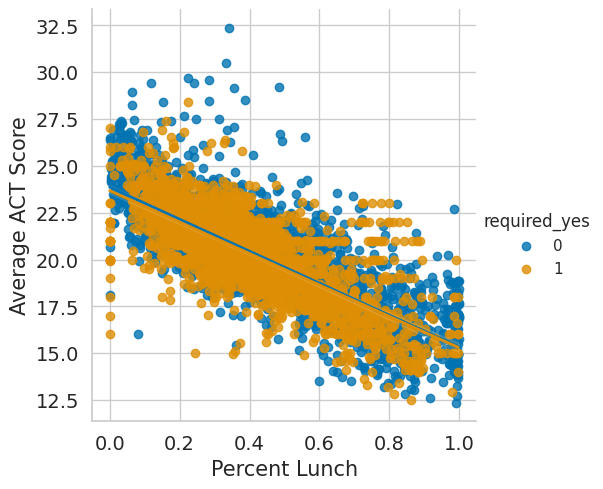

In [108]:
sns.lmplot(x="percent_lunch", y="average_act", hue="required_yes", data=df_merged, palette='colorblind', line_kws={'lw': 2})

plt.xlabel('Percent Lunch', fontsize=15)
plt.ylabel('Average ACT Score', fontsize=15)

plt.tick_params(labelsize=14);

There is a negative relationship between average ACT scores and students on free or reduced lunch.

Create a plot to show ACT scores by State.


In [109]:
import plotly.graph_objs as go
import plotly.offline as pyo

layout=dict(geo={'scope':'usa'}, title='ACT Scores by State')
data=dict(type='choropleth', locations=df_train['state'], locationmode='USA-states', z=df_train['average_act'], text=df_train['state'], colorscale='Viridis', colorbar={'title':'Average ACT Scores'})

fig=go.Figure(data=[data],layout=layout)

pyo.iplot(fig)


Following the plot, New York has the highest average ACT score at 29.2 while Louisiana had the lowest ACT average at 16.8. 

There is very limited data for each state and not all states are included. This may affect our analysis.

#### $\rightarrow$ Since the data does not include all the states, does this affect the relationship between ACT performance and socioeconomic factors?

Creating new models for percent lunch. If ACT is required, set to 0 otherwise, set ACT requirement to 1. 

In [110]:
model_lunch0 = smf.ols('average_act ~ percent_lunch + required_yes == 0', data=df_merged).fit()
print(model_lunch0.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     4714.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:48:49   Log-Likelihood:                -10748.
No. Observations:                5781   AIC:                         2.150e+04
Df Residuals:                    5778   BIC:                         2.152e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [111]:
model_lunch1 = smf.ols('average_act ~ percent_lunch + required_yes == 1', data=df_merged).fit()
print(model_lunch1.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     4714.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:48:49   Log-Likelihood:                -10748.
No. Observations:                5781   AIC:                         2.150e+04
Df Residuals:                    5778   BIC:                         2.152e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

Creating a model that includes both ACT required and not required.

In [112]:
model_lunch = smf.ols('average_act ~ percent_lunch', data=df_train).fit()
print(model_lunch.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9407.
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        00:48:50   Log-Likelihood:                -10753.
No. Observations:                5781   AIC:                         2.151e+04
Df Residuals:                    5779   BIC:                         2.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7861      0.041    577.051

Although the p-values are nearly 0.0, the r-squared values only differ by 0.001. Thus, the ACT requirement does not impact the relationship much.

## Conclusion

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To investigate, we included additional questions to help us analyze the provided data. We wanted to explore the relationships between ACT requirements across different states. 

Through our analysis we found that there is a negative relationiship between `average_act` and `percent_lunch`. We created regression models using these predictors to determine if the ACT requirement is useful for our analysis. However, we found that there is only a 0.001 difference between the two groups where ACT was required and not required. Thus, we can conclude that the ACT requirement has little to no impact when finding relationships between ACT performance and socioeconomic factors.

We came to the conlusion that there are limitations to our analysis due to missing significant predictors. The data provided did not include all the states and does not take the recent SAT changes from 2018 into account. These factors may have affected our results. Thus, using the states included in this data set as a predictor is not useful when finding relationships between ACT performance and socioeconomic factors.